In [1]:
import ann_visualizer
import copy
import datetime
from IPython.display import display, Image, SVG
import logging
import matplotlib.pyplot as plt
import numpy
import os
import pandas
import pickle
import plotly
import pyarrow.parquet as pq
import six
import tensorflow as tf

import CS230

#tf.enable_eager_execution()

# experiment 4 - LSTM

In [2]:
MODEL_NAME = 'model-4'

DATA_DIR = os.path.join('data', MODEL_NAME)
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

logger = CS230.common.get_logger()

In [3]:
FILE_PATHS = []

for dir_path, dir_names, file_names in os.walk(CS230.data.DATA_DIR):
    if dir_path.startswith('.'):
        continue
    
    for file_name in file_names:
        if file_name.endswith('.parquet'):
            file_path = os.path.join(dir_path, file_name)
            FILE_PATHS.append(file_path)
    
    if FILE_PATHS:
        break  # exit after loading files from 1 directory

FILE_PATHS.sort()
FILE_PATHS

['/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_01_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_02_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_02_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_03_03_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140221_04_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222_01_01_03_250lm.parquet',
 '/home/dave/code/github/davidcasterton/CS230_project/data/2014_Targa_Sixty-Six/20140222

In [4]:
df = CS230.data.load(FILE_PATHS[2])
df.columns

Index(['time', 'handwheelAngle', 'throttle', 'brake', 'clutch', 'engineSpeed',
       'PPS', 'gpsTime', 'latitude', 'longitude', 'altitude', 'vNorth',
       'vEast', 'vUp', 'horizontalSpeed', 'vxCG', 'vyCG', 'vzCG', 'axCG',
       'ayCG', 'azCG', 'yawAngle', 'pitchAngle', 'rollAngle', 'rollRate',
       'pitchRate', 'yawRate', 'sideSlip', 'distance', 'numSVsTracked',
       'gpsPosMode', 'gpsVelMode', 'gpsOrientMode', 'HDOP', 'PDOP',
       'posAccuracy_north', 'posAccuracy_east', 'posAccuracy_down',
       'velAccuracy_north', 'velAccuracy_east', 'velAccuracy_down',
       'orientAccuracy_heading', 'orientAccuracy_pitch', 'orientAccuracy_roll',
       'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR',
       'deflectionFL', 'deflectionFR', 'deflectionRR', 'wheelAccelFL',
       'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR'],
      dtype='object')

In [5]:
cols_in = ['axCG', 'ayCG', 'azCG', 'brake', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR', 
              'clutch', 'engineSpeed', 'handwheelAngle', 
              'horizontalSpeed', 'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'throttle', 'vxCG', 'vyCG', 'vzCG', 
              'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate']  
#'deflectionFL', 'deflectionFR', 'deflectionRL', 'deflectionRR', 

cols_out = ['axCG', 'ayCG', 'azCG', 'chassisAccelFL', 'chassisAccelFR', 'chassisAccelRL', 'chassisAccelRR',
               'horizontalSpeed',
               'pitchAngle', 'pitchRate', 'rollAngle', 'rollRate', 'vxCG', 'vyCG', 'vzCG',
               'wheelAccelFL', 'wheelAccelFR', 'wheelAccelRL', 'wheelAccelRR', 'yawAngle', 'yawRate']  
#'deflectionFL', 'deflectionFR', 'deflectionRL', 'deflectionRR',  

In [6]:
def add_labels(file_path, cols_in, cols_out):
    # build data (input) DataFrame
    df_data = CS230.data.load(file_path)
    df_data = CS230.data.stride_rows(df_data, stride=10)
    df_data.dropna(axis=0, inplace=True)
    #df_data, deriv_columns = CS230.data.add_derivatives(df_data, strides=strides, columns_to_deriv=df_data.columns)
    #cols_in = list(df_data.columns)

    # build labels
    df_labels = copy.deepcopy(df_data[cols_out])
    #df_labels, deriv_columns = CS230.data.add_derivatives(df_labels, strides=[1], columns_to_deriv=CS230.data.COLUMNS_MOTION)
    #df_labels = df_labels[deriv_columns]

    # update label column names to prepend "label_"
    label_map = {}
    for col in df_labels.columns:
        label_map[col] = 'label_' + col
    df_labels.rename(index=str, columns=label_map, inplace=True)
    cols_out = df_labels.columns

    # associate input data (prior timestamp) & output labels (next timestamp) on same row
    df_data = df_data.iloc[:-1].reset_index(drop=True)
    df_labels = df_labels.iloc[1:].reset_index(drop=True)

    # concatenate data to labels
    df_out = pandas.concat([df_data[cols_in], df_labels], axis=1, sort=False)
    del df_data
    del df_labels
    
    df_out.dropna(axis=0, inplace=True)
    
    return df_out, cols_in, cols_out

In [7]:
def split_data(train_files, dev_file, test_file, cols_in, cols_out):
    # shuffle order of combined data frame
    #df_out = df_out.sample(frac=1)
    
    df_train, cols_in, _cols_out = add_labels(FILE_PATHS[0], cols_in, cols_out)
    
    df_dev, cols_in, _cols_out = add_labels(FILE_PATHS[1], cols_in, cols_out)
    
    df_test, cols_in, _cols_out = add_labels(FILE_PATHS[2], cols_in, cols_out)
    

    return df_train, df_dev, df_test, cols_in, _cols_out

In [8]:
load_data_from_source = True

if load_data_from_source:
    file_path = FILE_PATHS[0]

    df_train, df_dev, df_test, cols_in, cols_out = split_data(
        FILE_PATHS[0], FILE_PATHS[1], FILE_PATHS[2], cols_in=cols_in, cols_out=cols_out)

    df_train.to_parquet(os.path.join(DATA_DIR, 'in_train.parquet'))
    df_dev.to_parquet(os.path.join(DATA_DIR, 'in_dev.parquet'))
    df_test.to_parquet(os.path.join(DATA_DIR, 'in_test.parquet'))
    with open(os.path.join(DATA_DIR, 'in_cols_in.pickle'), 'wb') as f:
        pickle.dump(cols_in, f)
    with open(os.path.join(DATA_DIR, 'in_cols_out.pickle'), 'wb') as f:
        pickle.dump(cols_out, f)

else:
    
    table = pq.read_table(os.path.join(DATA_DIR, 'in_train.parquet'))
    df_train = table.to_pandas()
    table = pq.read_table(os.path.join(DATA_DIR, 'in_dev.parquet'))
    df_dev = table.to_pandas()
    table = pq.read_table(os.path.join(DATA_DIR, 'in_test.parquet'))
    df_test = table.to_pandas()
    with open(os.path.join(DATA_DIR, 'in_cols_in.pickle'), 'rb') as f:
        cols_in = pickle.load(f)
    with open(os.path.join(DATA_DIR, 'in_cols_out.pickle'), 'rb') as f:
        cols_out = pickle.load(f)

In [9]:
df_train.head()

,axCG,ayCG,azCG,brake,chassisAccelFL,chassisAccelFR,chassisAccelRL,chassisAccelRR,clutch,engineSpeed,...,label_rollRate,label_vxCG,label_vyCG,label_vzCG,label_wheelAccelFL,label_wheelAccelFR,label_wheelAccelRL,label_wheelAccelRR,label_yawAngle,label_yawRate
0,0.94,0.23,7.78,0.0,9.300,9.398,7.564,10.094,0.0,1890,...,-3.60,6.13,-0.28,-0.24,8.73,9.52,12.07,7.85,-13.96,5.81
1,0.94,0.23,7.78,0.0,8.545,10.094,9.398,9.781,0.0,1890,...,-3.60,6.13,-0.28,-0.26,7.75,10.59,10.20,9.12,-13.90,5.81
2,0.94,0.23,7.78,0.0,9.349,9.663,9.594,10.889,0.0,1914,...,2.02,6.12,-0.26,-0.24,8.63,11.38,9.81,9.71,-13.91,5.32
3,0.19,1.52,10.73,0.0,9.300,9.320,8.584,10.860,0.0,1914,...,2.02,6.11,-0.25,-0.23,9.71,9.71,7.95,10.50,-13.86,5.32
4,0.19,1.52,10.73,0.0,9.349,8.427,7.279,10.359,0.0,1914,...,2.02,6.11,-0.25,-0.22,10.40,8.63,7.65,9.61,-13.81,5.32


In [10]:
df_train[cols_in].head()

,axCG,ayCG,azCG,brake,chassisAccelFL,chassisAccelFR,chassisAccelRL,chassisAccelRR,clutch,engineSpeed,...,throttle,vxCG,vyCG,vzCG,wheelAccelFL,wheelAccelFR,wheelAccelRL,wheelAccelRR,yawAngle,yawRate
0,0.94,0.23,7.78,0.0,9.300,9.398,7.564,10.094,0.0,1890,...,11.8,6.12,-0.27,-0.22,8.63,10.30,10.99,7.06,-14.01,5.81
1,0.94,0.23,7.78,0.0,8.545,10.094,9.398,9.781,0.0,1890,...,11.8,6.13,-0.28,-0.24,8.73,9.52,12.07,7.85,-13.96,5.81
2,0.94,0.23,7.78,0.0,9.349,9.663,9.594,10.889,0.0,1914,...,11.8,6.13,-0.28,-0.26,7.75,10.59,10.20,9.12,-13.90,5.81
3,0.19,1.52,10.73,0.0,9.300,9.320,8.584,10.860,0.0,1914,...,11.8,6.12,-0.26,-0.24,8.63,11.38,9.81,9.71,-13.91,5.32
4,0.19,1.52,10.73,0.0,9.349,8.427,7.279,10.359,0.0,1914,...,12.0,6.11,-0.25,-0.23,9.71,9.71,7.95,10.50,-13.86,5.32


In [11]:
df_train[cols_out].head()

,label_axCG,label_ayCG,label_azCG,label_chassisAccelFL,label_chassisAccelFR,label_chassisAccelRL,label_chassisAccelRR,label_horizontalSpeed,label_pitchAngle,label_pitchRate,...,label_rollRate,label_vxCG,label_vyCG,label_vzCG,label_wheelAccelFL,label_wheelAccelFR,label_wheelAccelRL,label_wheelAccelRR,label_yawAngle,label_yawRate
0,0.94,0.23,7.78,8.545,10.094,9.398,9.781,6.14,-2.93,-1.06,...,-3.60,6.13,-0.28,-0.24,8.73,9.52,12.07,7.85,-13.96,5.81
1,0.94,0.23,7.78,9.349,9.663,9.594,10.889,6.14,-2.94,-1.06,...,-3.60,6.13,-0.28,-0.26,7.75,10.59,10.20,9.12,-13.90,5.81
2,0.19,1.52,10.73,9.300,9.320,8.584,10.860,6.13,-2.89,0.81,...,2.02,6.12,-0.26,-0.24,8.63,11.38,9.81,9.71,-13.91,5.32
3,0.19,1.52,10.73,9.349,8.427,7.279,10.359,6.12,-2.88,0.81,...,2.02,6.11,-0.25,-0.23,9.71,9.71,7.95,10.50,-13.86,5.32
4,0.19,1.52,10.73,9.977,9.879,6.818,11.174,6.12,-2.88,0.81,...,2.02,6.11,-0.25,-0.22,10.40,8.63,7.65,9.61,-13.81,5.32


In [12]:
df_train[cols_in].shape

(49095, 26)

In [13]:
df_train[cols_out].shape

(49095, 21)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


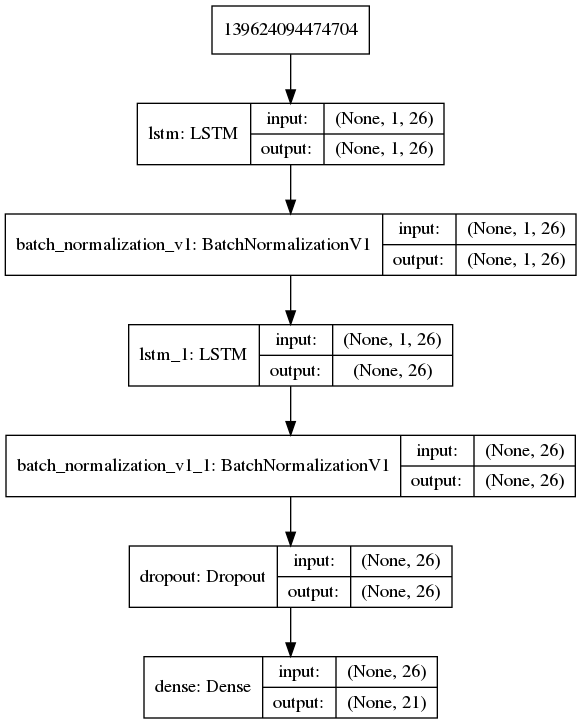

In [14]:
data_dim = len(cols_in)
label_dim = len(cols_out)
timesteps = 1

model = tf.keras.Sequential()

#model.add(tf.keras.layers.BatchNormalization())

#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(len(cols_in), input_dim=len(cols_in), activation='sigmoid'))

#model.add(tf.keras.layers.BatchNormalization(axis=-1))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(len(cols_in), activation='relu'))

#model.add(tf.keras.layers.BatchNormalization())

#model.add(tf.keras.layers.BatchNormalization(input_shape=(timesteps, data_dim)))

model.add(tf.keras.layers.LSTM(data_dim, return_sequences=True, input_shape=(timesteps, data_dim),
                               dropout=0.1, recurrent_dropout=0.1))

model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(data_dim, dropout=0.1, recurrent_dropout=0.1))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(label_dim, activation='linear'))

# summarize model
#model.summary()

# sudo apt install python-pydot python-pydot-ng graphviz
file_path = os.path.join(DATA_DIR, 'model.png')
tf.keras.utils.plot_model(model, file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))

In [15]:
#optimizer = tf.train.AdamOptimizer(0.01)
optimizer = tf.keras.optimizers.Adam(0.01, decay=0.0001)
#optimizer = tf.keras.optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(
    optimizer=optimizer, 
    loss='mean_squared_error', 
    metrics=['mean_absolute_error']
)

Instructions for updating:
Use tf.cast instead.


In [16]:
x_train = numpy.reshape(df_train[cols_in].values, (df_train[cols_in].shape[0], 1, df_train[cols_in].shape[1]))
#y_train = numpy.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))

In [17]:
x_train.shape

(49095, 1, 26)

In [18]:
x_train = tf.cast(x_train, tf.float64)
y_train = tf.cast(df_train[cols_out].values, tf.float64)

In [19]:
checkpoint_path = os.path.join(DATA_DIR, 'cp.ckpt')
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='mean_absolute_error', verbose=1, save_weights_only=True, save_best_only=True, mode='max')

In [20]:
history = model.fit(x_train, y_train, epochs=50, steps_per_epoch=50, callbacks = [cp_callback])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
49/50 [============================>.] - ETA: 0s - loss: 322.3040 - mean_absolute_error: 6.9679
Epoch 00001: mean_absolute_error improved from -inf to 6.93400, saving model to data/model-4/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
50/50 [==============================] - 2s 42ms/step - loss: 321.1320 - mean_absolute_error: 6.9340
Epoch 2/50
49/50 [============================>.] - ETA: 0s - loss: 236.1450 - mean_absolute_error: 4.1335
Epoch 00002: mean_absolute_error did not improve from 6.93400
50/50 [==============================] - 1s 19ms/step - loss: 235.9249 - mean_absolute_error: 4.1267
Epoch 3/50
49/50 [============================>.] - ETA: 0s - loss: 225.1146 - mean_absolute_error: 3.7730
Epoch 00003: mean_absolute_error did not improve from 6.93400
50/50 [==========

Epoch 28/50
49/50 [============================>.] - ETA: 0s - loss: 93.2490 - mean_absolute_error: 2.7678
Epoch 00028: mean_absolute_error did not improve from 6.93400
50/50 [==============================] - 1s 19ms/step - loss: 93.2448 - mean_absolute_error: 2.7677
Epoch 29/50
49/50 [============================>.] - ETA: 0s - loss: 93.1648 - mean_absolute_error: 2.7589
Epoch 00029: mean_absolute_error did not improve from 6.93400
50/50 [==============================] - 1s 19ms/step - loss: 93.1429 - mean_absolute_error: 2.7589
Epoch 30/50
49/50 [============================>.] - ETA: 0s - loss: 93.1838 - mean_absolute_error: 2.7541
Epoch 00030: mean_absolute_error did not improve from 6.93400
50/50 [==============================] - 1s 20ms/step - loss: 93.2086 - mean_absolute_error: 2.7540
Epoch 31/50
49/50 [============================>.] - ETA: 0s - loss: 93.5901 - mean_absolute_error: 2.7541
Epoch 00031: mean_absolute_error did not improve from 6.93400
50/50 [=================

Text(0.5, 0, 'epoch')

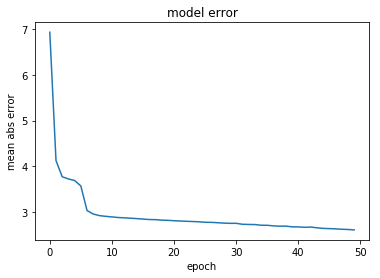

In [21]:
plt.plot(history.history['mean_absolute_error'])
#plt.plot(history.history['val_acc'])
plt.title('model error')
plt.ylabel('mean abs error')
plt.xlabel('epoch')

In [22]:
model.save(os.path.join(DATA_DIR, 'model_%s.h5' % datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [23]:
x_dev = numpy.reshape(df_dev[cols_in].values, (df_dev[cols_in].shape[0], 1, df_dev[cols_in].shape[1]))
x_dev = tf.cast(x_dev, tf.float32)
y_dev = tf.cast(df_dev[cols_out].values, tf.float32)

In [24]:
dev_predictions = model.predict(x_dev, steps=1)

In [25]:
df_dev_predictions = pandas.DataFrame(dev_predictions, columns=cols_out)

In [26]:
df_dev[cols_in].head()

,axCG,ayCG,azCG,brake,chassisAccelFL,chassisAccelFR,chassisAccelRL,chassisAccelRR,clutch,engineSpeed,...,throttle,vxCG,vyCG,vzCG,wheelAccelFL,wheelAccelFR,wheelAccelRL,wheelAccelRR,yawAngle,yawRate
0,0.36,-0.56,9.80,0.0,9.83,9.928,9.163,9.182,0.0,0,...,0.2,-0.01,-0.02,0.02,10.2,9.91,8.14,7.85,-4.31,0.56
1,-0.24,0.66,9.83,0.0,9.81,9.928,9.163,9.153,0.0,0,...,0.2,-0.01,-0.01,0.02,10.4,10.10,8.14,8.04,-4.31,0.06
2,-0.19,0.54,9.56,0.0,9.83,9.898,9.182,9.133,0.0,0,...,0.2,-0.01,-0.01,0.01,10.5,10.10,8.44,7.85,-4.30,-0.32
3,0.05,0.08,9.97,0.0,9.83,9.898,9.231,9.182,0.0,0,...,0.2,-0.01,-0.01,0.02,10.3,9.71,8.24,8.14,-4.30,-0.21
4,0.14,-0.08,9.67,0.0,9.83,9.898,9.212,9.202,0.0,0,...,0.2,-0.01,-0.01,0.02,10.3,10.10,8.14,7.95,-4.29,0.09


In [27]:
df_dev[cols_out].head()

,label_axCG,label_ayCG,label_azCG,label_chassisAccelFL,label_chassisAccelFR,label_chassisAccelRL,label_chassisAccelRR,label_horizontalSpeed,label_pitchAngle,label_pitchRate,...,label_rollRate,label_vxCG,label_vyCG,label_vzCG,label_wheelAccelFL,label_wheelAccelFR,label_wheelAccelRL,label_wheelAccelRR,label_yawAngle,label_yawRate
0,-0.24,0.66,9.83,9.81,9.928,9.163,9.153,0.01,-0.03,-0.00,...,-0.18,-0.01,-0.01,0.02,10.40,10.10,8.14,8.04,-4.31,0.06
1,-0.19,0.54,9.56,9.83,9.898,9.182,9.133,0.01,-0.03,-0.05,...,0.22,-0.01,-0.01,0.01,10.50,10.10,8.44,7.85,-4.30,-0.32
2,0.05,0.08,9.97,9.83,9.898,9.231,9.182,0.01,-0.03,-0.04,...,-0.13,-0.01,-0.01,0.02,10.30,9.71,8.24,8.14,-4.30,-0.21
3,0.14,-0.08,9.67,9.83,9.898,9.212,9.202,0.01,-0.03,0.03,...,0.21,-0.01,-0.01,0.02,10.30,10.10,8.14,7.95,-4.29,0.09
4,-0.09,0.40,10.06,9.83,9.898,9.163,9.182,0.01,-0.03,0.11,...,-0.21,-0.01,-0.01,0.02,10.01,9.91,8.14,7.75,-4.29,-0.13


In [28]:
df_dev_predictions.head()

,label_axCG,label_ayCG,label_azCG,label_chassisAccelFL,label_chassisAccelFR,label_chassisAccelRL,label_chassisAccelRR,label_horizontalSpeed,label_pitchAngle,label_pitchRate,...,label_rollRate,label_vxCG,label_vyCG,label_vzCG,label_wheelAccelFL,label_wheelAccelFR,label_wheelAccelRL,label_wheelAccelRR,label_yawAngle,label_yawRate
0,-0.006999,0.172701,9.326714,9.379206,9.436843,8.828701,8.832142,0.186210,0.003049,-0.000315,...,0.007995,0.173235,-0.002353,-0.00393,9.669205,9.406610,7.836693,7.707218,-4.422631,-0.048185
1,-0.006998,0.172672,9.326742,9.379236,9.436871,8.828697,8.832142,0.186308,0.003049,-0.000316,...,0.007994,0.173333,-0.002353,-0.00393,9.669243,9.406639,7.836727,7.707237,-4.422499,-0.048264
2,-0.006998,0.172685,9.326729,9.379222,9.436857,8.828699,8.832142,0.186262,0.003049,-0.000316,...,0.007995,0.173286,-0.002353,-0.00393,9.669225,9.406626,7.836711,7.707228,-4.422564,-0.048228
3,-0.006999,0.172697,9.326717,9.379210,9.436846,8.828701,8.832142,0.186221,0.003049,-0.000315,...,0.007995,0.173246,-0.002353,-0.00393,9.669209,9.406613,7.836698,7.707220,-4.422616,-0.048195
4,-0.006999,0.172696,9.326718,9.379210,9.436847,8.828700,8.832142,0.186224,0.003049,-0.000315,...,0.007995,0.173249,-0.002353,-0.00393,9.669210,9.406614,7.836699,7.707221,-4.422614,-0.048197


In [29]:
error = df_dev.reset_index(drop=True)[cols_out] - df_dev_predictions[cols_out]

In [30]:
error.head()

,label_axCG,label_ayCG,label_azCG,label_chassisAccelFL,label_chassisAccelFR,label_chassisAccelRL,label_chassisAccelRR,label_horizontalSpeed,label_pitchAngle,label_pitchRate,...,label_rollRate,label_vxCG,label_vyCG,label_vzCG,label_wheelAccelFL,label_wheelAccelFR,label_wheelAccelRL,label_wheelAccelRR,label_yawAngle,label_yawRate
0,-0.233001,0.487299,0.503286,0.430794,0.491157,0.334299,0.320858,-0.176210,-0.033049,0.000315,...,-0.187995,-0.183235,-0.007647,0.02393,0.730795,0.693390,0.303307,0.332782,0.112631,0.108185
1,-0.183002,0.367328,0.233258,0.450764,0.461129,0.353303,0.300858,-0.176308,-0.033049,-0.049684,...,0.212006,-0.183333,-0.007647,0.01393,0.830757,0.693361,0.603273,0.142763,0.122499,-0.271736
2,0.056998,-0.092685,0.643271,0.450778,0.461143,0.402301,0.349858,-0.176262,-0.033049,-0.039684,...,-0.137995,-0.183286,-0.007647,0.02393,0.630775,0.303374,0.403289,0.432772,0.122564,-0.161772
3,0.146999,-0.252697,0.343283,0.450790,0.461154,0.383299,0.369858,-0.176221,-0.033049,0.030315,...,0.202005,-0.183246,-0.007647,0.02393,0.630791,0.693387,0.303302,0.242780,0.132616,0.138195
4,-0.083001,0.227304,0.733282,0.450790,0.461153,0.334300,0.349858,-0.176224,-0.033049,0.110315,...,-0.217995,-0.183249,-0.007647,0.02393,0.340790,0.503386,0.303301,0.042779,0.132614,-0.081803
